In [1]:
from molmap.extend.kekulescope import dataset
from molmap.extend.kekulescope import featurizer
from molmap import model as molmodel
import molmap

import matplotlib.pyplot as plt

import pandas as pd
from tqdm import tqdm
from joblib import load, dump
tqdm.pandas(ascii=True)
import numpy as np


%matplotlib inline
#use GPU, if negative value, CPUs will be used
import os
os.environ["CUDA_VISIBLE_DEVICES"]="6"


import tensorflow as tf
seed = 777
np.random.seed(seed)
tf.compat.v1.set_random_seed(seed)


In [2]:
dataset.cell_lines

['A2780', 'CCRF-CEM', 'DU-145', 'HCT-15', 'KB', 'LoVo', 'PC-3', 'SK-OV-3']

In [3]:
cell_line = 'HCT-15'

In [4]:
df = dataset.load_data(cell_line)
df = df[~df.pIC50.isna()].reset_index(drop=True)

In [5]:
mp1 = molmap.loadmap('../descriptor_grid_split.mp')
mp2 = molmap.loadmap('../fingerprint_grid_split.mp')


if not os.path.exists('X1.data'):
    X1 = mp1.batch_transform(df.smiles, n_jobs = 8)
    dump(X1, './X1.data')
else:
    X1 = load('./X1.data')
    
    
if not os.path.exists('X2.data'): 
    X2 = mp2.batch_transform(df.smiles)
    dump(X2, './X2.data')
else:
    X2 = load('./X2.data')

In [6]:
Y = df['pIC50'].astype('float').values.reshape(-1,1)

In [7]:
def split(df, random_state = 123, split_size = [0.7, 0.15, 0.15]):
    from sklearn.utils import shuffle
    base_indices = np.arange(len(df))
    base_indices = shuffle(base_indices, random_state  = random_state)
    nb_test = int(len(base_indices) * split_size[2])
    nb_val = int(len(base_indices) * split_size[1])

    test_idx = base_indices[1:nb_test]
    valid_idx = base_indices[(nb_test+1):(nb_test+nb_val)]
    train_idx = base_indices[(nb_test+nb_val+1):len(base_indices)]

    print(len(train_idx), len(valid_idx), len(test_idx))
    return train_idx, valid_idx, test_idx
train_idx, valid_idx, test_idx = split(df, random_state = 1)

695 148 148


In [8]:
trainX = (X1[train_idx], X2[train_idx])
trainY = Y[train_idx]

validX = (X1[valid_idx], X2[valid_idx])
validY = Y[valid_idx]

testX = (X1[test_idx], X2[test_idx])
testY = Y[test_idx]

In [9]:
molmap1_size = X1.shape[1:]
molmap2_size = X2.shape[1:]


performace = molmodel.cbks.Reg_EarlyStoppingAndPerformance((trainX, trainY), 
                                                           (validX, validY), 
                                                           patience = 20, 
                                                           criteria = 'val_loss')

model = molmodel.net.DoublePathNet(molmap1_size, molmap2_size, 
                                   n_outputs=1, dense_layers=[256, 128, 32], 
                                   dense_avf='relu', last_avf='linear')

opt = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0) #
#import tensorflow_addons as tfa
#opt = tfa.optimizers.AdamW(weight_decay = 0.1,learning_rate=0.001,beta1=0.9,beta2=0.999, epsilon=1e-08)
model.compile(optimizer = opt, loss = 'mse')
model.count_params()

136767

In [10]:
model.fit(trainX, trainY, batch_size=128, 
      epochs=500, verbose= 0, shuffle = True, 
      validation_data = (validX, validY), 
      callbacks=[performace]) 

epoch: 0001, loss: 34.5207 - val_loss: 32.1990; rmse: 5.5960 - rmse_val: 5.6744;  r2: 0.0002 - r2_val: 0.0029                                                                                                    
epoch: 0002, loss: 29.2995 - val_loss: 26.1972; rmse: 5.0401 - rmse_val: 5.1183;  r2: 0.0009 - r2_val: 0.0105                                                                                                    
epoch: 0003, loss: 22.3314 - val_loss: 17.0460; rmse: 4.0517 - rmse_val: 4.1287;  r2: 0.0013 - r2_val: 0.0134                                                                                                    
epoch: 0004, loss: 12.1950 - val_loss: 5.6846; rmse: 2.3380 - rmse_val: 2.3842;  r2: 0.0018 - r2_val: 0.0194                                                                                                    
epoch: 0005, loss: 3.2080 - val_loss: 2.4967; rmse: 1.7739 - rmse_val: 1.5801;  r2: 0.0020 - r2_val: 0.0224                                                      

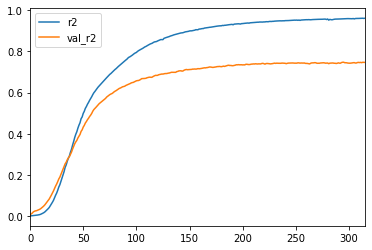

In [18]:
dfp = pd.DataFrame(performace.history)[['r2', 'val_r2']]
dfp.plot()

In [12]:
performace.evaluate(trainX, trainY) # RMSE, R^2

([0.27987170382719045], [0.9583731286788505])

In [13]:
performace.evaluate(validX, validY) # RMSE, R^2

([0.6549937275073038], [0.7471698486130297])

In [14]:
performace.evaluate(testX, testY) # RMSE, R^2

([0.7146983690417512], [0.7232110065052503])

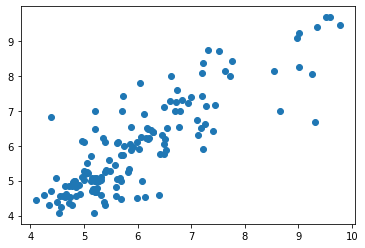

In [15]:
plt.scatter(performace.model.predict(testX), testY)